In [1]:
import sys
import os
import numpy as np
from PIL import Image
import datetime

import torch
import torch.nn as nn
from torch import optim

import matplotlib.pyplot as plt

In [2]:
def get_ids(directory):
    """Returns a list of the ids in the directory"""
    return (f[:-4] for f in os.listdir(directory))

# In[255]:
#def load_img(ids, directory, suffix):
#    for iid in ids:
#        
#        img = Image.open(directory + iid + suffix)
#        img = img.resize((640,360))
#        img = np.array(img)
#        yield img
        
def load_img2(iid, directory, suffix):
        
    img = Image.open(directory + iid + suffix)
#     img = img.resize((640,360))
    img = img.resize((640,256))

#    img = img.resize((320,180))

    img = np.array(img)
        
    return img

# In[256]:
#def load_mask(ids, directory, suffix):
#    for iid in ids:
#        
#        msk = Image.open(directory + iid + "_drivable_id" + suffix)
#        msk = msk.resize((640,360))
#        msk = np.array(msk).astype('float32')
#        yield msk
        
def load_mask2(iid, directory, suffix):
        
    msk = Image.open(directory + iid + "_drivable_id" + suffix)
    msk = msk.resize((640,360))
#    msk = msk.resize((320,180))

    msk = np.array(msk).astype('float32')
    return msk

# In[257]:
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

# In[258]:
def normalize(x):
    return np.float32(x/255.)

In [3]:
epochs = 100
batch_size = 1
lr = 0.0001
save_cp = False
gpu = False
load = True

In [5]:
from unet import UNet_multiclass

net = UNet_multiclass(n_channels=3, n_classes=3)

if gpu: 
    net.cuda()
    
if load:
    weights = "checkpoints/driveable/BDD_3_CP19.pth"
    if torch.cuda.is_available():
        net.load_state_dict(torch.load(weights))
    else:
        net.load_state_dict(torch.load(weights, map_location='cpu'))
    print('Model loaded from {}'.format(weights))
    
net.eval()

Model loaded from checkpoints/driveable/BDD_3_CP19.pth


UNet_multiclass(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(12

In [40]:
dir_img_train = "/home/kenny/Desktop/lanes-segmentation/data/images/2018-12-10/"

ids_train = get_ids(dir_img_train)

iddataset = dict()

iddataset['train'] = list(ids_train)

# iddataset['train'] = iddataset['train'][:5]

N_train = len(iddataset['train'])

In [41]:
N_train

107

In [42]:
i = 4

path = '2018-12-10-59'

img = load_img2(path, dir_img_train, '.png')
img2 = hwc_to_chw(img)
img2 = normalize(img2)
img2 = np.expand_dims(img2, axis = 0)                

img2 = torch.from_numpy(img2)

if gpu:
    img2 = img2.cuda()
    
with torch.no_grad():
    mask_pred = net(img2)

y_pred = mask_pred.cpu().numpy()

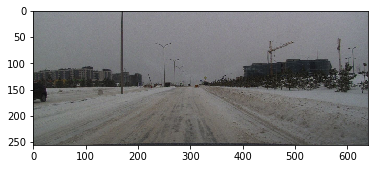

In [43]:
plt.imshow(img)

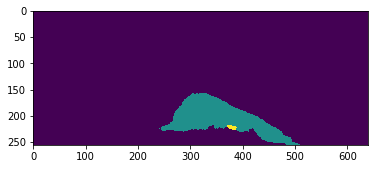

In [44]:
plt.imshow(np.argmax(y_pred[0], axis=0))

In [45]:
b = np.argmax(y_pred[0], axis=0)

In [46]:
show = img.copy()
for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        if b[i,j] == 1:
            show[i,j] = (0,0,255)
        elif b[i,j] == 2:
            show[i,j] = (255,0,0)

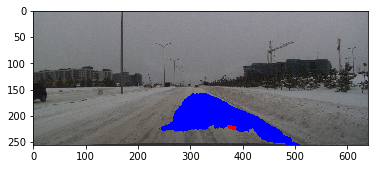

In [47]:
plt.imshow(show)

In [48]:
show2 = Image.fromarray(show)
show2.save("kia_val_pred_3", "PNG")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(15,10)

for i in range(N_train):

    path = iddataset['train'][i]

    img = load_img2(path, dir_img_train, '.png')
    img2 = hwc_to_chw(img)
    img2 = normalize(img2)
    img2 = np.expand_dims(img2, axis = 0)                

    img2 = torch.from_numpy(img2)

    if gpu:
        img2 = img2.cuda()

    with torch.no_grad():
        mask_pred = net(img2)

    y_pred = mask_pred.cpu().numpy()

    axes.imshow(img)
    axes.imshow(np.argmax(y_pred[0], axis=0), alpha=0.33)
    fig.tight_layout()
    fig.savefig('results/KiaBDD/2018-11-30/img{}.png'.format(i))
    
    print(i)